### Student Information
Name: 彭星樺

Student ID: 113065507

GitHub ID: ktpss97094

---

### Instructions

1. First: do the **take home** exercises in the [DM2024-Lab1-Master](https://github.com/didiersalazar/DM2024-Lab1-Master.git). You may need to copy some cells from the Lab notebook to this notebook. __This part is worth 20% of your grade.__


2. Second: follow the same process from the [DM2024-Lab1-Master](https://github.com/didiersalazar/DM2024-Lab1-Master.git) on **the new dataset**. You don't need to explain all details as we did (some **minimal comments** explaining your code are useful though).  __This part is worth 30% of your grade.__
    - Download the [the new dataset](https://huggingface.co/datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data). The dataset contains a `sentiment` and `comment` columns, with the sentiment labels being: 'nostalgia' and 'not nostalgia'. Read the specificiations of the dataset for background details. 
    - You are allowed to use and modify the `helper` functions in the folder of the first lab session (notice they may need modification) or create your own.


3. Third: please attempt the following tasks on **the new dataset**. __This part is worth 30% of your grade.__
    - Generate meaningful **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    - Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency). Refer to this Scikit-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .
    - Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Note that for the TF-IDF features you might need to use other type of NB classifier different than the one in the Master Notebook. Comment on the differences.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).


4. Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be handled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets? __This part is worth 10% of your grade.__


5. Fifth: It's hard for us to follow if your code is messy, so please **tidy up your notebook** and **add minimal comments where needed**. __This part is worth 10% of your grade.__


You can submit your homework following these guidelines: [Git Intro & How to hand your homework](https://github.com/didiersalazar/DM2024-Lab1-Master/blob/main/Git%20Intro%20%26%20How%20to%20hand%20your%20homework.ipynb). Make sure to commit and save your changes to your repository __BEFORE the deadline (October 27th 11:59 pm, Sunday)__. 

In [2]:
### Begin Assignment Here
%load_ext autoreload
%autoreload 2

In [3]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

from sklearn.datasets import fetch_20newsgroups

twenty_train = fetch_20newsgroups(subset='train', categories=categories,
                                  shuffle=True, random_state=42) 

In [4]:
# Exercise 1
for text in twenty_train.data[:3]:
    print(text)

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.

From: ani@ms.uky.edu (Aniruddha B. Deglurkar)
Subject: help: Splitting a trimming region along a mesh 
Organization: University Of Kentucky, Dept. of Math Sciences
Lines: 28



	Hi,

	I have a problem, I hope some of the 'gurus' can help me solve.

	Background of the problem:
	I have a rectangular mesh in the uv

In [5]:
import pandas as pd

# my functions
import helpers.data_mining_helpers as dmh

# construct dataframe from a list
X = pd.DataFrame.from_records(dmh.format_rows(twenty_train), columns= ['text'])

X['category'] = twenty_train.target
X['category_name'] = X.category.apply(lambda t: dmh.format_labels(t, twenty_train))

In [6]:
# Exercise 2
X.iat[0, 0]

'From: sd345@city.ac.uk (Michael Collier) Subject: Converting images to HP LaserJet III? Nntp-Posting-Host: hampton Organization: The City University Lines: 14  Does anyone know of a good way (standard PC application/PD utility) to convert tif/img/tga files into LaserJet III format.  We would also like to do the same, converting to HPGL (HP plotter) files.  Please email any response.  Is this the correct group?  Thanks in advance.  Michael. --  Michael Collier (Programmer)                 The Computer Unit, Email: M.P.Collier@uk.ac.city                The City University, Tel: 071 477-8000 x3769                      London, Fax: 071 477-8565                            EC1V 0HB. '

In [7]:
# Exercise 3
X[X["category_name"] == "sci.med"][::10][:5]

,text,category,category_name
7,From: aldridge@netcom.com (Jacquelin Aldridge)...,2,sci.med
49,From: jimj@contractor.EBay.Sun.COM (Jim Jones)...,2,sci.med
82,From: jason@ab20.larc.nasa.gov (Jason Austin) ...,2,sci.med
118,From: rogers@calamari.hi.com (Andrew Rogers) S...,2,sci.med
142,From: lady@uhunix.uhcc.Hawaii.Edu (Lee Lady) S...,2,sci.med


In [8]:
# Exercise 4
X.isnull().apply(lambda x: dmh.check_missing_values(x), axis=1)

0       (The amoung of missing records is: , 0)
1       (The amoung of missing records is: , 0)
2       (The amoung of missing records is: , 0)
3       (The amoung of missing records is: , 0)
4       (The amoung of missing records is: , 0)
                         ...                   
2252    (The amoung of missing records is: , 0)
2253    (The amoung of missing records is: , 0)
2254    (The amoung of missing records is: , 0)
2255    (The amoung of missing records is: , 0)
2256    (The amoung of missing records is: , 0)
Length: 2257, dtype: object

In [9]:
# Exercise 5
'''
Id C, D, and F's missing_example attributes they used strings but not "None" or np.nan to represent missing values.

According to isnull() documentation (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html#pandas.DataFrame.isnull), "NA values, such as None or numpy.NaN, gets mapped to True values. Everything else gets mapped to False values."

Id C, D, and F's missing_example attributes are not None or numpy.NaN, so the isnull() values are False.

This will omit missing values that are represented in strings.
'''

'\nId C, D, and F\'s missing_example attributes they used strings but not "None" or np.nan to represent missing values.\n\nAccording to isnull() documentation (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html#pandas.DataFrame.isnull), "NA values, such as None or numpy.NaN, gets mapped to True values. Everything else gets mapped to False values."\n\nId C, D, and F\'s missing_example attributes are not None or numpy.NaN, so the isnull() values are False.\n\nThis will omit missing values that are represented in strings.\n'

In [10]:
# Exercise 6
X_sample = X.sample(n=1000)

'''
X's record order is always in increment order, but X_sample's is not.
'''

"\nX's record order is always in increment order, but X_sample's is not.\n"

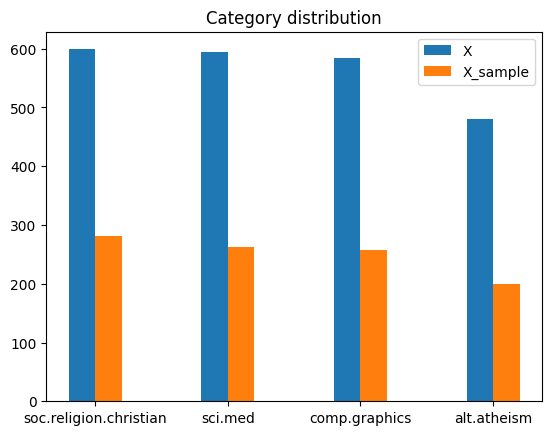

In [11]:
# Exercise 8

import matplotlib.pyplot as plt
%matplotlib inline

X_valCnts = X.category_name.value_counts()
X_sample_valCnts = X_sample.category_name.value_counts()
upper_bound = max(max(X_valCnts) , max(X_sample_valCnts)) + 50

# let 2 series appear at a same plot
plt.bar(X_valCnts.index, X.category_name.value_counts(), align='edge', width=-0.2, label='X')
plt.bar(X_sample_valCnts.index, X_sample.category_name.value_counts(), align='edge', width=0.2, label='X_sample')

plt.title('Category distribution')
plt.xticks(X_valCnts.index)

plt.legend()
plt.show()

In [12]:
import nltk
nltk.download('punkt_tab')

X['unigrams'] = X['text'].apply(lambda x: dmh.tokenize_text(x))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ktpss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.text) #learn the vocabulary and return document-term matrix
print(X_counts[0])

  (np.int32(0), np.int32(14887))	1
  (np.int32(0), np.int32(29022))	1
  (np.int32(0), np.int32(8696))	4
  (np.int32(0), np.int32(4017))	2
  (np.int32(0), np.int32(33256))	2
  (np.int32(0), np.int32(21661))	3
  (np.int32(0), np.int32(9031))	3
  (np.int32(0), np.int32(31077))	1
  (np.int32(0), np.int32(9805))	2
  (np.int32(0), np.int32(17366))	1
  (np.int32(0), np.int32(32493))	4
  (np.int32(0), np.int32(16916))	2
  (np.int32(0), np.int32(19780))	2
  (np.int32(0), np.int32(17302))	2
  (np.int32(0), np.int32(23122))	1
  (np.int32(0), np.int32(25663))	1
  (np.int32(0), np.int32(16881))	1
  (np.int32(0), np.int32(16082))	1
  (np.int32(0), np.int32(23915))	1
  (np.int32(0), np.int32(32142))	5
  (np.int32(0), np.int32(33597))	2
  (np.int32(0), np.int32(20253))	1
  (np.int32(0), np.int32(587))	1
  (np.int32(0), np.int32(12051))	1
  (np.int32(0), np.int32(5201))	1
  :	:
  (np.int32(0), np.int32(25361))	1
  (np.int32(0), np.int32(25337))	1
  (np.int32(0), np.int32(12833))	2
  (np.int32(0), np.in

In [14]:
# Exercise 10
import numpy as np

# find the second nonzero element index
count_vect.get_feature_names_out()[np.flatnonzero(X_counts[4, 0:100].toarray().squeeze())[1]]

'01'

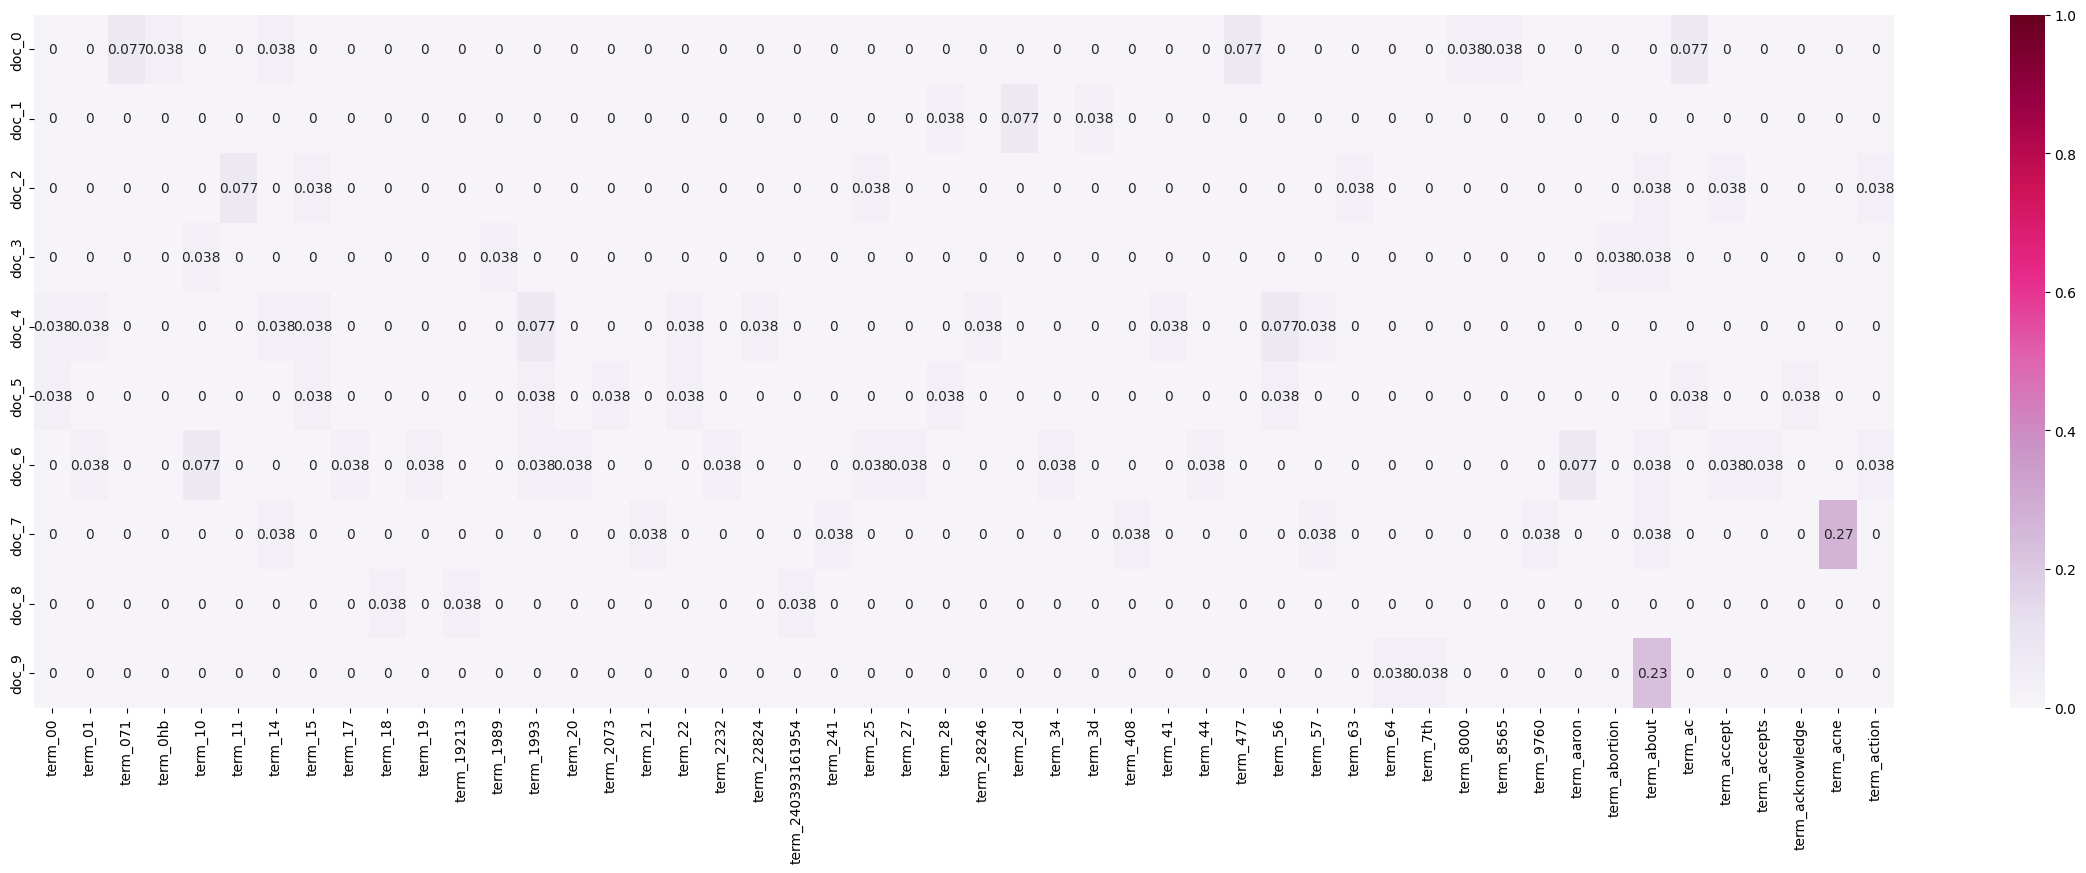

In [15]:
# Excercise 11
import seaborn as sns

def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

DOC_NUM = 10

plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()]
plot_y = ["doc_"+ str(i) for i in list(X.index)[0:DOC_NUM]]
plot_z = X_counts[0:DOC_NUM].toarray()

# remove all 0 columns
reserved_col = ~np.all(plot_z == 0, axis=0)
plot_x = np.array(plot_x)[reserved_col]
plot_z = plot_z[:, reserved_col]

# normalize to [0, 1]
plot_z = normalization(plot_z)

# only show first 50
plot_x = plot_x[:50]
plot_z = plot_z[:, :50]

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(30, 9))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=1, annot=True)

In [16]:
# Exercise 12
term_frequencies = []
for j in range(0,X_counts.shape[1]):
    term_frequencies.append(sum(X_counts[:,j].toarray()))

term_frequencies = np.asarray(X_counts.sum(axis=0))[0]

import plotly.express as px
fig = px.bar(x=count_vect.get_feature_names_out()[:300], y=term_frequencies[:300])
fig.show()

C:\Users\ktpss\AppData\Local\Temp\ipykernel_5300\970350315.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, '10'),
 Text(1, 0, '15'),
 Text(2, 0, '16'),
 Text(3, 0, '1993'),
 Text(4, 0, '20'),
 Text(5, 0, 'about'),
 Text(6, 0, 'ac'),
 Text(7, 0, 'actually'),
 Text(8, 0, 'after'),
 Text(9, 0, 'again'),
 Text(10, 0, 'all'),
 Text(11, 0, 'also'),
 Text(12, 0, 'am'),
 Text(13, 0, 'an'),
 Text(14, 0, 'and'),
 Text(15, 0, 'another'),
 Text(16, 0, 'any'),
 Text(17, 0, 'anyone'),
 Text(18, 0, 'anything'),
 Text(19, 0, 'apr'),
 Text(20, 0, 'are'),
 Text(21, 0, 'argument'),
 Text(22, 0, 'article'),
 Text(23, 0, 'as'),
 Text(24, 0, 'at'),
 Text(25, 0, 'atheism'),
 Text(26, 0, 'atheists'),
 Text(27, 0, 'available'),
 Text(28, 0, 'back'),
 Text(29, 0, 'banks'),
 Text(30, 0, 'based'),
 Text(31, 0, 'be'),
 Text(32, 0, 'because'),
 Text(33, 0, 'been'),
 Text(34, 0, 'before'),
 Text(35, 0, 'being'),
 Text(36, 0, 'believe'),
 Text(37, 0, 'best'),
 Text(38, 0, 'better'),
 Text(39, 0, 'between'),
 Text(40, 0, 'bible'),
 Text(41, 0, 'bit'),
 Text(42, 0, 'book'),
 Text(43, 0, 'both'),
 Text(44, 0, 'bu

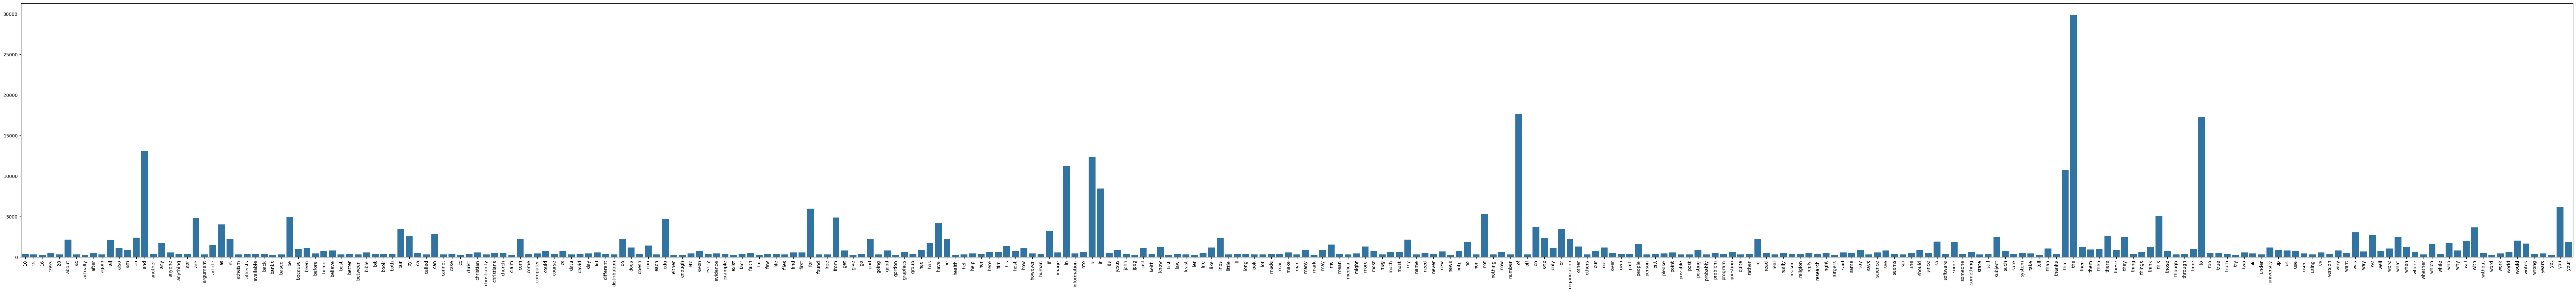

In [17]:
# Exercise 13
import heapq

# only shows top 300 most frequently occurring terms
value_300th_largest = heapq.nlargest(300, term_frequencies)[-1]
largest_300_indices = np.where(term_frequencies > value_300th_largest)

plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[largest_300_indices], 
            y=term_frequencies[largest_300_indices])
g.set_xticklabels(count_vect.get_feature_names_out()[largest_300_indices], rotation = 90)

C:\Users\ktpss\AppData\Local\Temp\ipykernel_5300\3279549428.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'the'),
 Text(1, 0, 'of'),
 Text(2, 0, 'to'),
 Text(3, 0, 'and'),
 Text(4, 0, 'is'),
 Text(5, 0, 'in'),
 Text(6, 0, 'that'),
 Text(7, 0, 'it'),
 Text(8, 0, 'you'),
 Text(9, 0, 'for'),
 Text(10, 0, 'not'),
 Text(11, 0, 'this'),
 Text(12, 0, 'be'),
 Text(13, 0, 'from'),
 Text(14, 0, 'are'),
 Text(15, 0, 'edu'),
 Text(16, 0, 'have'),
 Text(17, 0, 'as'),
 Text(18, 0, 'on'),
 Text(19, 0, 'with'),
 Text(20, 0, 'but'),
 Text(21, 0, 'or'),
 Text(22, 0, 'if'),
 Text(23, 0, 'was'),
 Text(24, 0, 'can'),
 Text(25, 0, 'we'),
 Text(26, 0, 'there'),
 Text(27, 0, 'by'),
 Text(28, 0, 'what'),
 Text(29, 0, 'subject'),
 Text(30, 0, 'they'),
 Text(31, 0, 'an'),
 Text(32, 0, 'lines'),
 Text(33, 0, 'one'),
 Text(34, 0, 'he'),
 Text(35, 0, 'god'),
 Text(36, 0, 'do'),
 Text(37, 0, 'organization'),
 Text(38, 0, 'at'),
 Text(39, 0, 're'),
 Text(40, 0, 'com'),
 Text(41, 0, 'about'),
 Text(42, 0, 'my'),
 Text(43, 0, 'all'),
 Text(44, 0, 'would'),
 Text(45, 0, 'will'),
 Text(46, 0, 'so'),
 Text(47, 0, 

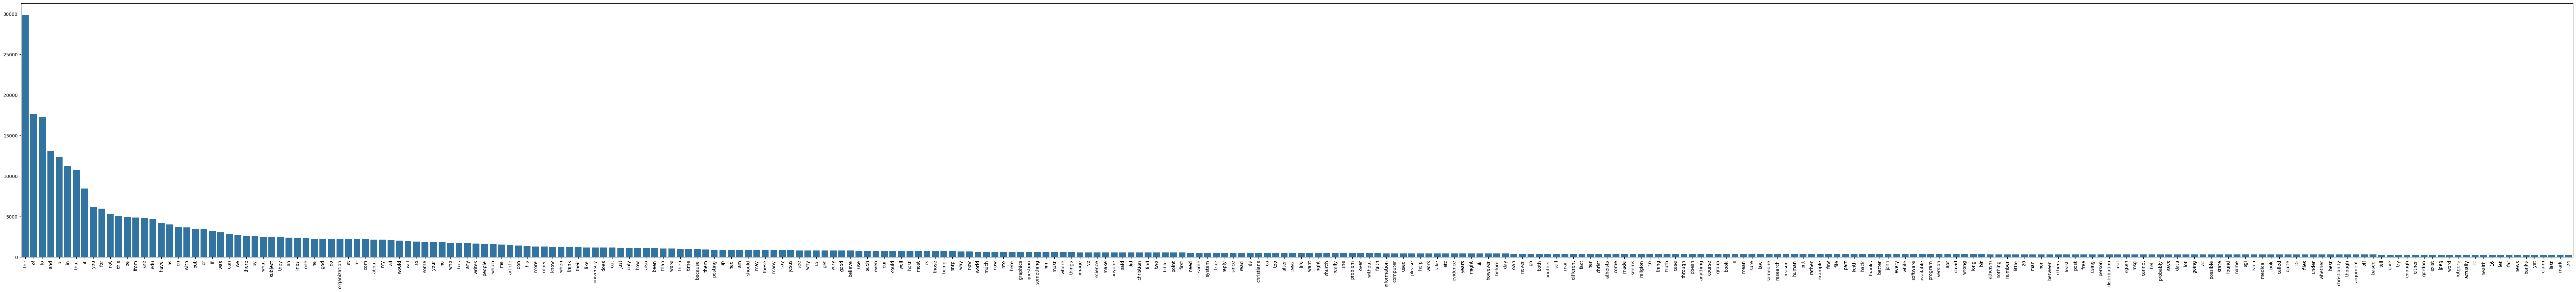

In [25]:
# Exercise 14
# descending sort
sorted_value = np.argsort(term_frequencies)[::-1]

plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[sorted_value][:300], 
            y=term_frequencies[sorted_value][:300])
g.set_xticklabels(count_vect.get_feature_names_out()[sorted_value], rotation = 90)

C:\Users\ktpss\AppData\Local\Temp\ipykernel_5300\1341123276.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'the'),
 Text(1, 0, 'of'),
 Text(2, 0, 'to'),
 Text(3, 0, 'and'),
 Text(4, 0, 'is'),
 Text(5, 0, 'in'),
 Text(6, 0, 'that'),
 Text(7, 0, 'it'),
 Text(8, 0, 'you'),
 Text(9, 0, 'for'),
 Text(10, 0, 'not'),
 Text(11, 0, 'this'),
 Text(12, 0, 'be'),
 Text(13, 0, 'from'),
 Text(14, 0, 'are'),
 Text(15, 0, 'edu'),
 Text(16, 0, 'have'),
 Text(17, 0, 'as'),
 Text(18, 0, 'on'),
 Text(19, 0, 'with'),
 Text(20, 0, 'but'),
 Text(21, 0, 'or'),
 Text(22, 0, 'if'),
 Text(23, 0, 'was'),
 Text(24, 0, 'can'),
 Text(25, 0, 'we'),
 Text(26, 0, 'there'),
 Text(27, 0, 'by'),
 Text(28, 0, 'what'),
 Text(29, 0, 'subject'),
 Text(30, 0, 'they'),
 Text(31, 0, 'an'),
 Text(32, 0, 'lines'),
 Text(33, 0, 'one'),
 Text(34, 0, 'he'),
 Text(35, 0, 'god'),
 Text(36, 0, 'do'),
 Text(37, 0, 'organization'),
 Text(38, 0, 'at'),
 Text(39, 0, 're'),
 Text(40, 0, 'com'),
 Text(41, 0, 'about'),
 Text(42, 0, 'my'),
 Text(43, 0, 'all'),
 Text(44, 0, 'would'),
 Text(45, 0, 'will'),
 Text(46, 0, 'so'),
 Text(47, 0, 

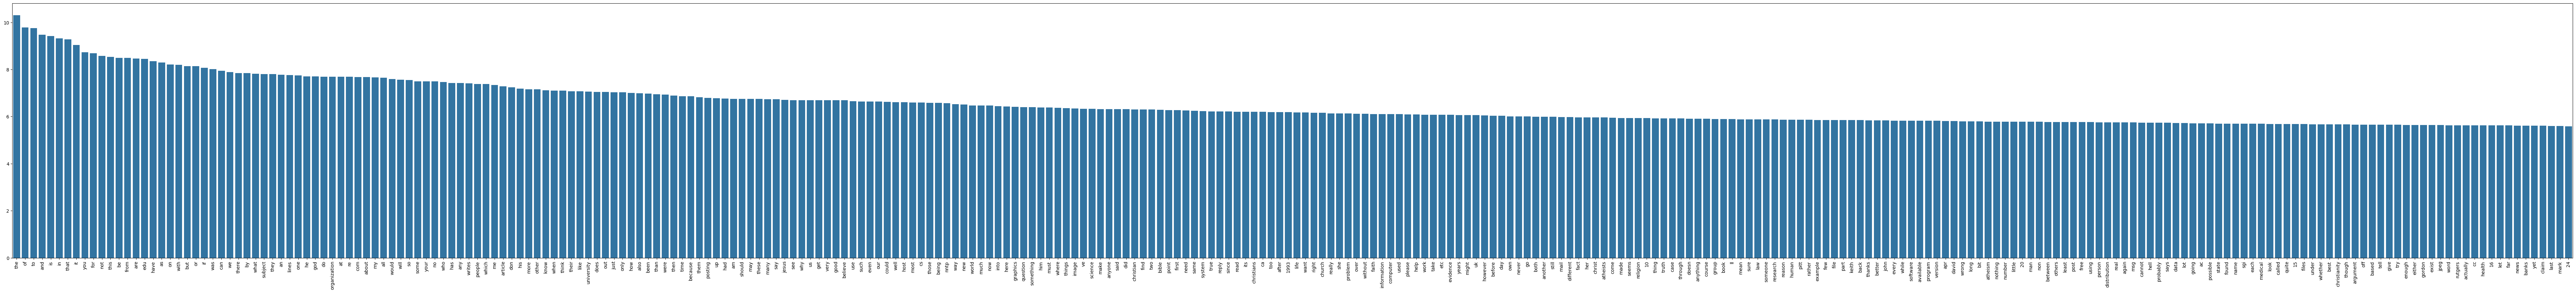

In [24]:
# Exercise 15
import math
term_frequencies_log = np.array([math.log(i) for i in term_frequencies])

# descending sort
sorted_log_value = np.argsort(term_frequencies_log)[::-1]

plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[sorted_log_value][:300], 
            y=term_frequencies_log[sorted_log_value][:300])
g.set_xticklabels(count_vect.get_feature_names_out()[sorted_log_value], rotation = 90)

C:\Users\ktpss\AppData\Local\Temp\ipykernel_5300\2025492413.py:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\ktpss\AppData\Local\Temp\ipykernel_5300\2025492413.py:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'the'),
 Text(1, 0, 'of'),
 Text(2, 0, 'to'),
 Text(3, 0, 'and'),
 Text(4, 0, 'is'),
 Text(5, 0, 'in'),
 Text(6, 0, 'that'),
 Text(7, 0, 'it'),
 Text(8, 0, 'you'),
 Text(9, 0, 'for'),
 Text(10, 0, 'not'),
 Text(11, 0, 'this'),
 Text(12, 0, 'be'),
 Text(13, 0, 'from'),
 Text(14, 0, 'are'),
 Text(15, 0, 'edu'),
 Text(16, 0, 'have'),
 Text(17, 0, 'as'),
 Text(18, 0, 'on'),
 Text(19, 0, 'with'),
 Text(20, 0, 'but'),
 Text(21, 0, 'or'),
 Text(22, 0, 'if'),
 Text(23, 0, 'was'),
 Text(24, 0, 'can'),
 Text(25, 0, 'we'),
 Text(26, 0, 'there'),
 Text(27, 0, 'by'),
 Text(28, 0, 'what'),
 Text(29, 0, 'subject'),
 Text(30, 0, 'they'),
 Text(31, 0, 'an'),
 Text(32, 0, 'lines'),
 Text(33, 0, 'one'),
 Text(34, 0, 'he'),
 Text(35, 0, 'god'),
 Text(36, 0, 'do'),
 Text(37, 0, 'organization'),
 Text(38, 0, 'at'),
 Text(39, 0, 're'),
 Text(40, 0, 'com'),
 Text(41, 0, 'about'),
 Text(42, 0, 'my'),
 Text(43, 0, 'all'),
 Text(44, 0, 'would'),
 Text(45, 0, 'will'),
 Text(46, 0, 'so'),
 Text(47, 0, 

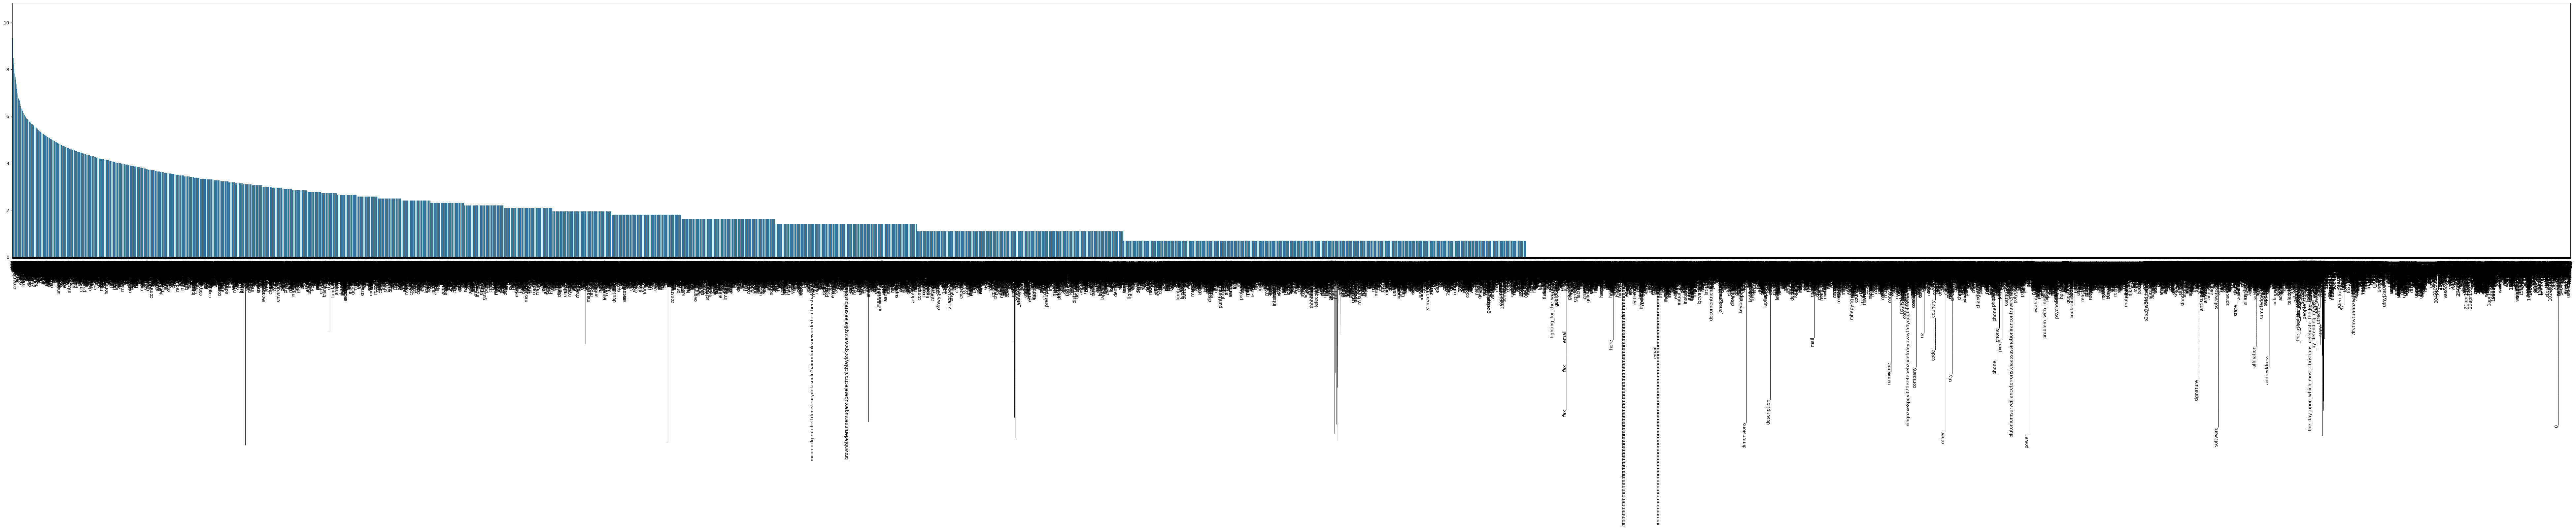

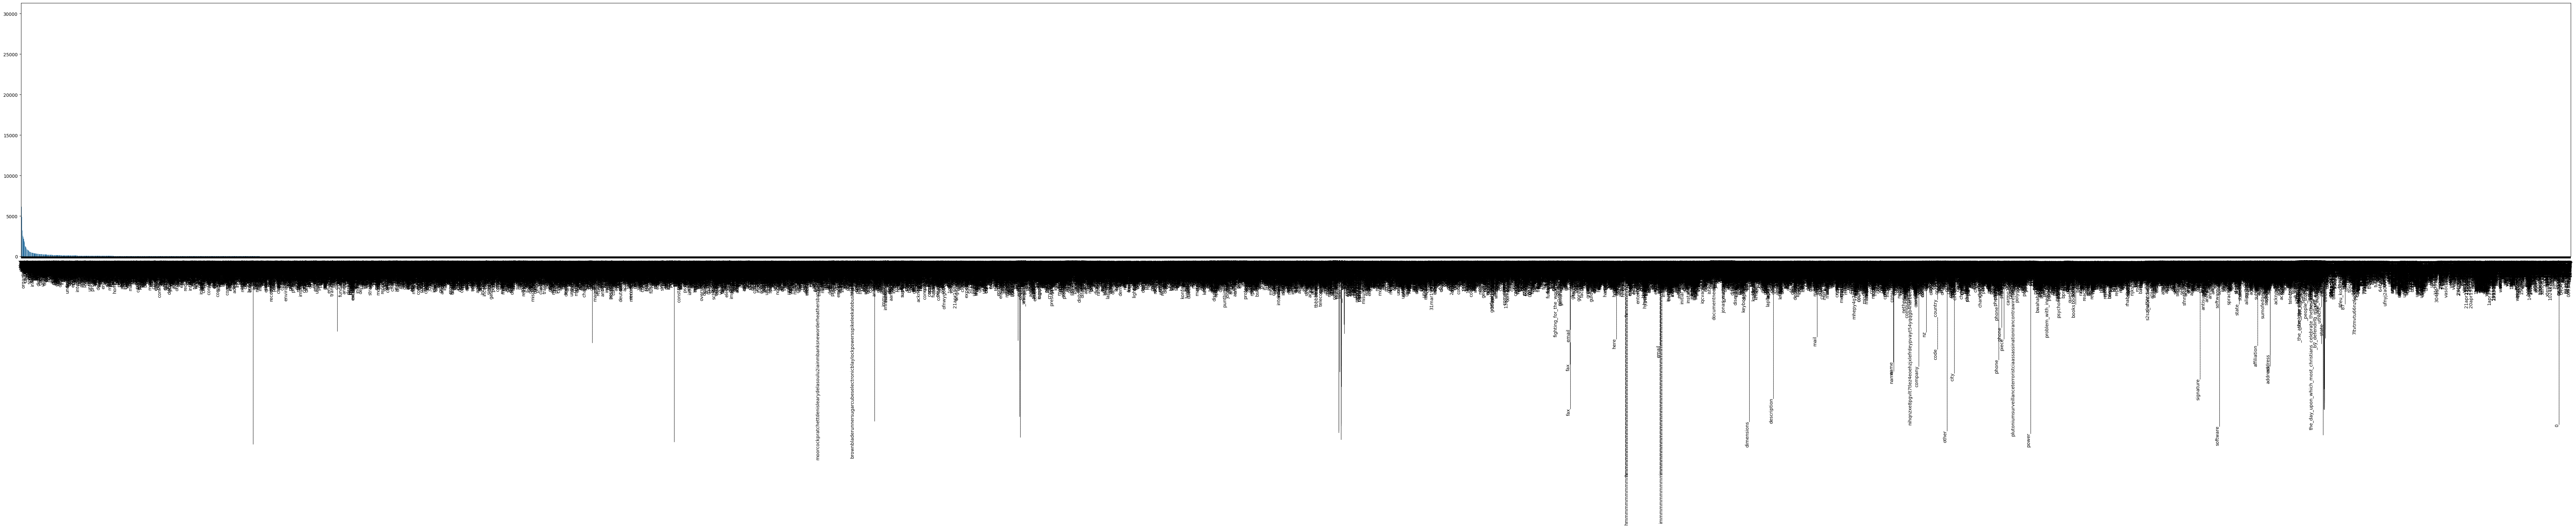

In [27]:
'''
When plotting only the first 300 most frequent terms, it is more difficult to see "long tail" with log than without log (the distribution looks flat with log); 
but when plotting all terms, it is easier to see "long tail" with log than without log (the distribution looks flat without log).
'''

plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[sorted_log_value], 
            y=term_frequencies_log[sorted_log_value])
g.set_xticklabels(count_vect.get_feature_names_out()[sorted_log_value], rotation = 90)

plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[sorted_value], 
            y=term_frequencies[sorted_value])
g.set_xticklabels(count_vect.get_feature_names_out()[sorted_value], rotation = 90)